# Integrated Emotion and Gender Classification

This notebook combines the Emotion and Gender classification models into a single workflow. It includes all functions, parameters, debugging code, and testing from both models. At the end, the models will be exported for use in other applications.

## Emotion Classification Model

# Emotion Classification Model - IPYNB

pip install numpy tensorflow scikit-learn matplotlib

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
# Define parameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
l2_strength = 0.002  # L2 regularization strength

- Modify this based on the path of the training & testing dataset

In [3]:
# Directories
train_dir = 'C:/Users/Melvin Tang/OneDrive/Codes/I2ML/FINALPRO/archive/train'

test_dirs = [
    'C:/Users/Melvin Tang/OneDrive/Codes/I2ML/FINALPRO/archive/testgeli',
    'C:/Users/Melvin Tang/OneDrive/Codes/I2ML/FINALPRO/archive/testkevin',
    'C:/Users/Melvin Tang/OneDrive/Codes/I2ML/FINALPRO/archive/test'
]


In [20]:

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=16,  # Randomly rotate images by up to 16 degrees
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=VALIDATION_SPLIT,  # Use validation split
)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,  # Resize images to target size
    color_mode='grayscale',  # Load images in grayscale
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For categorical labels (e.g., softmax output)
    subset='training'  # Subset for training
)

# Validation Data Generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,  # Resize images to target size
    color_mode='grayscale',  # Load images in grayscale
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For categorical labels
    subset='validation',  # Subset for validation
    shuffle=False  # Do not shuffle validation data
)


Found 20011 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [5]:
# Categories for the classes
categories = list(train_generator.class_indices.keys())

# Compute Class Weights
labels = train_generator.classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

In [21]:
# Model Definition
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_strength), input_shape=(48, 48, 1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_strength)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Reduced dropout rate

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_strength)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_strength)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Reduced dropout rate

    # Third Convolutional Block
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_strength)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_strength)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),  # Reduced dropout rate

    # Fourth Convolutional Block (Added)
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_strength)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_strength)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),  # Maintained dropout rate

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(512, kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(l2_strength)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),  # Reduced dropout rate
    layers.Dense(5, activation='softmax')
])

- Model Compiling, Loss Functions and Callbacks 
(Utilized early stopping and learning rate reducer)

In [22]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00035)  # Reduced learning rate

# Using label smoothing
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [23]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
626/626 [==============================] - 67s 104ms/step - loss: 10.4695 - accuracy: 0.2308 - val_loss: 8.4987 - val_accuracy: 0.2478 - lr: 3.5000e-04
Epoch 2/100
626/626 [==============================] - 17s 28ms/step - loss: 6.8587 - accuracy: 0.2955 - val_loss: 5.1717 - val_accuracy: 0.3324 - lr: 3.5000e-04
Epoch 3/100
626/626 [==============================] - 16s 25ms/step - loss: 4.1504 - accuracy: 0.3748 - val_loss: 3.1845 - val_accuracy: 0.3892 - lr: 3.5000e-04
Epoch 4/100
626/626 [==============================] - 16s 25ms/step - loss: 2.7376 - accuracy: 0.4423 - val_loss: 2.4834 - val_accuracy: 0.3540 - lr: 3.5000e-04
Epoch 5/100
626/626 [==============================] - 15s 25ms/step - loss: 2.1319 - accuracy: 0.4889 - val_loss: 1.8872 - val_accuracy: 0.5272 - lr: 3.5000e-04
Epoch 6/100
626/626 [==============================] - 15s 25ms/step - loss: 1.8908 - accuracy: 0.5110 - val_loss: 1.8675 - val_accuracy: 0.4540 - lr: 3.5000e-04
Epoch 7/100
626/626 [=====

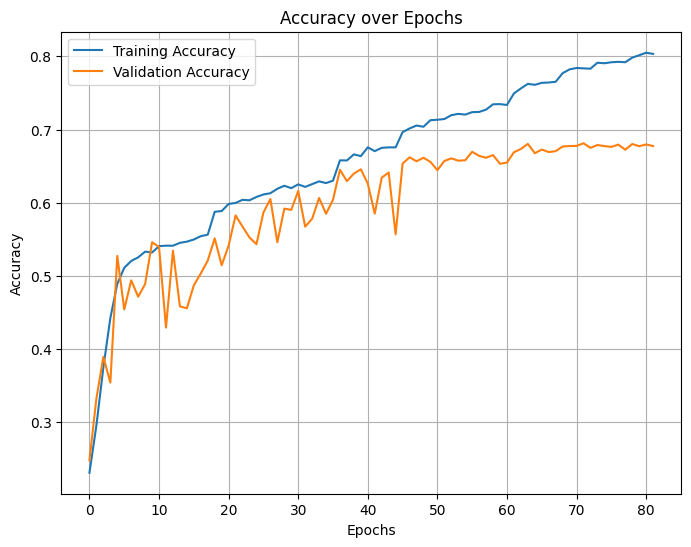

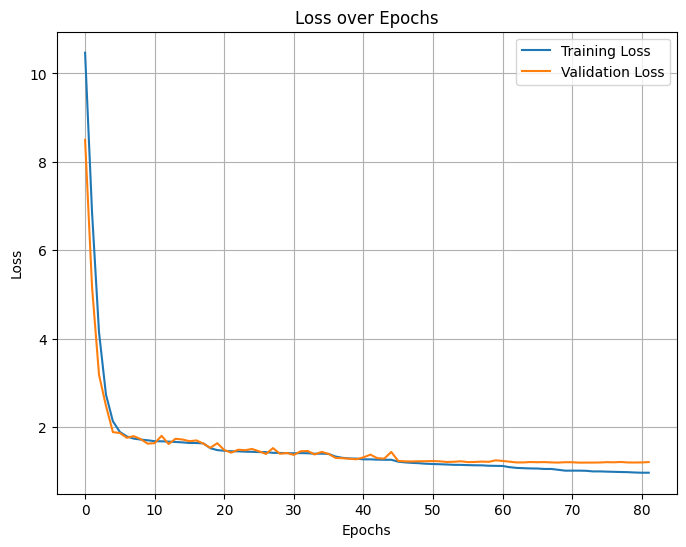

Final Training Accuracy: 0.8034
Final Validation Accuracy: 0.6774
Final Training Loss: 0.9693
Final Validation Loss: 1.2101


In [24]:
# Plotting functions
def plot_accuracy(history):
    plt.figure(figsize=(8,6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)
plot_loss(history)

# Retrieve the final training and validation accuracy and loss
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final training and validation accuracy and loss
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Found 5 images belonging to 5 classes.
1/1 [==============================] - 0s 62ms/step - loss: 2.8939 - accuracy: 0.2000

Test Directory: C:/Users/Melvin Tang/OneDrive/Codes/I2ML/FINALPRO/archive/testgeli
Test Accuracy: 0.2000, Test Loss: 2.8939
1/1 [==============================] - 0s 211ms/step
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         1
        fear       0.00      0.00      0.00         1
       happy       0.20      1.00      0.33         1
     neutral       0.00      0.00      0.00         1
         sad       0.00      0.00      0.00         1

    accuracy                           0.20         5
   macro avg       0.04      0.20      0.07         5
weighted avg       0.04      0.20      0.07         5



e:\Programs\AnacondaEnvironment\envs\py310MLGPU\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Programs\AnacondaEnvironment\envs\py310MLGPU\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Programs\AnacondaEnvironment\envs\py310MLGPU\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

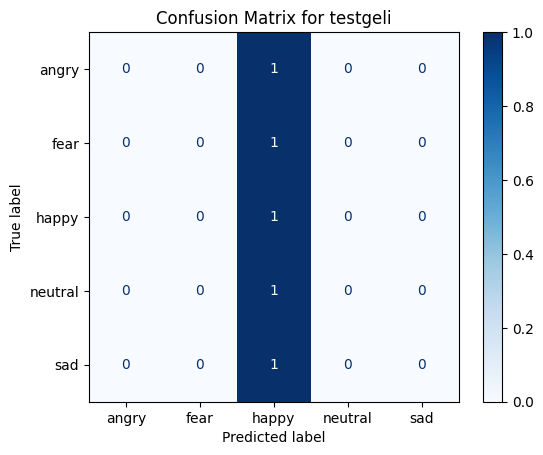

Found 5 images belonging to 5 classes.
1/1 [==============================] - 0s 38ms/step - loss: 1.3938 - accuracy: 0.4000

Test Directory: C:/Users/Melvin Tang/OneDrive/Codes/I2ML/FINALPRO/archive/testkevin
Test Accuracy: 0.4000, Test Loss: 1.3938
1/1 [==============================] - 0s 33ms/step
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         1
        fear       0.00      0.00      0.00         1
       happy       0.50      1.00      0.67         1
     neutral       0.00      0.00      0.00         1
         sad       0.33      1.00      0.50         1

    accuracy                           0.40         5
   macro avg       0.17      0.40      0.23         5
weighted avg       0.17      0.40      0.23         5



e:\Programs\AnacondaEnvironment\envs\py310MLGPU\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Programs\AnacondaEnvironment\envs\py310MLGPU\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Programs\AnacondaEnvironment\envs\py310MLGPU\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

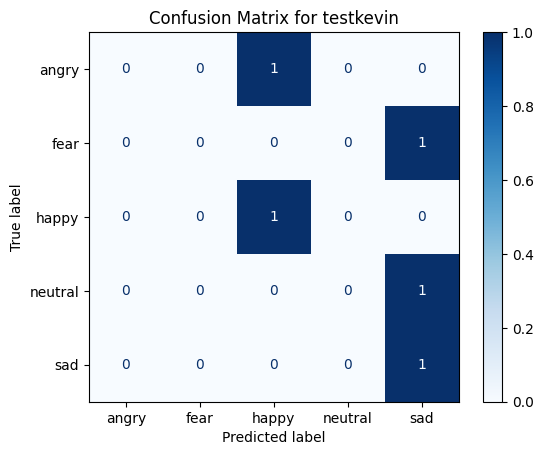

Found 6216 images belonging to 5 classes.
195/195 [==============================] - 44s 228ms/step - loss: 1.2113 - accuracy: 0.6845

Test Directory: C:/Users/Melvin Tang/OneDrive/Codes/I2ML/FINALPRO/archive/test
Test Accuracy: 0.6845, Test Loss: 1.2113
195/195 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

       angry       0.62      0.65      0.63       955
        fear       0.62      0.51      0.56      1020
       happy       0.91      0.87      0.89      1771
     neutral       0.60      0.71      0.65      1225
         sad       0.58      0.58      0.58      1245

    accuracy                           0.68      6216
   macro avg       0.66      0.66      0.66      6216
weighted avg       0.69      0.68      0.68      6216



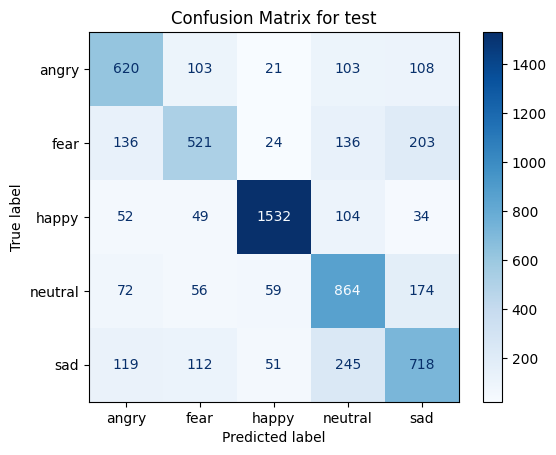

In [28]:
# Function to create a test data generator for a given directory
def create_test_generator(test_dir):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        color_mode='grayscale',  # Keeping RGB as in your original code
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    return test_generator

# Evaluate the model on multiple test sets
def evaluate_test_set(model, test_generator, test_dir, categories):
    # Evaluate
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'\nTest Directory: {test_dir}')
    print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

    # Predictions and classification report
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    print(classification_report(true_classes, predicted_classes, target_names=categories))

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {os.path.basename(test_dir)}')
    plt.show()

# Loop through each test directory and evaluate
for test_dir in test_dirs:
    test_generator = create_test_generator(test_dir)
    evaluate_test_set(model, test_generator, test_dir, categories)

In [11]:
# After training your model or loading it
# model.save('C:/Users/LENOVO/Downloads/real-time-emotion-recognition/cnn_trial.h5')  # Save it as .h5 format

## Gender Classification Model

In [29]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib  # For saving the model

male_dir = "C:/Users/Melvin Tang/OneDrive/Codes/I2ML/FINALPRO/archive/gender/Training/male"
female_dir = "C:/Users/Melvin Tang/OneDrive/Codes/I2ML/FINALPRO/archive/gender/Training/female"

image_paths = []
labels = []

# Max number of images to load from each directory
max_images = 10000

# Load male images (limit   to 2000)
print("Loading male images")
male_count = 0
for filename in os.listdir(male_dir):
    if male_count >= max_images:
        break
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_paths.append(os.path.join(male_dir, filename))
        labels.append(0)  # Male label = 0
        male_count += 1

# Load female images (limit to 2000)
print("Loading female images")
female_count = 0
for filename in os.listdir(female_dir):
    if female_count >= max_images:
        break
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_paths.append(os.path.join(female_dir, filename))
        labels.append(1)  # Female label = 1
        female_count += 1

labels = np.array(labels)

# Function to preprocess images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (128, 128))
    return resized_image

# Preprocess all images
print("Pre-process")
processed_images = [preprocess_image(image_path) for image_path in image_paths]

# Function to extract HOG features
def extract_hog_features(image):
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

print("Extracting HOG features")
hog_features = [extract_hog_features(img) for img in processed_images]

# Convert HOG features to numpy array
hog_features = np.array(hog_features)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

# Train the SVM classifier
print("Training SVM")
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train)

# Evaluate the model
print("Evaluate Model")
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the trained model to a file
print("Saving the model")
joblib.dump(svm, 'gender_classifier_model.pkl')  # Save as .pkl or .joblib



Loading male images
Loading female images
Pre-process
Extracting HOG features
Training SVM
Evaluate Model
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2019
           1       0.88      0.88      0.88      1981

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

Saving the model


['gender_classifier_model.pkl']

## Export Models

In [30]:

# Save both models as .h5 files
model.save("emotion_model.h5")
print("Emotion model saved as emotion_model.h5")

#gender_model.save("gender_model.h5")
#print("Gender model saved as gender_model.h5")


Emotion model saved as emotion_model.h5
